In [2]:
import os,sys,inspect

import pnsolver

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

import util
import stencil
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

import ipywidgets as widgets
from ipywidgets.widgets.interaction import interact

import scipy.io


## Multigrid: Standard Poisson Problem vs. PN-Problem

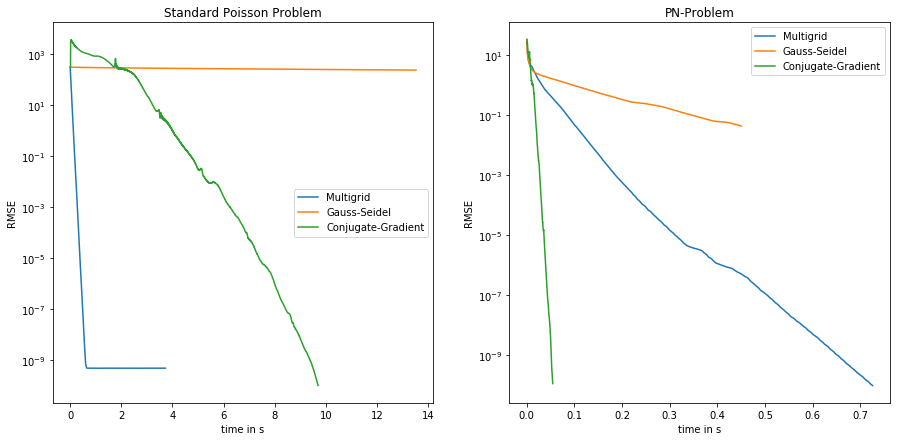

In [69]:
def plot_timings( filename ):
    data = scipy.io.loadmat(filename)
    convergence_mg = data["convergence_mg"][0]
    convergence_time_mg = data["timestamps_mg"][0]
    convergence_gs = data["convergence_gs"][0]
    convergence_time_gs = data["timestamps_gs"][0]
    convergence_cg = data["convergence_cg"][0]
    convergence_time_cg = data["timestamps_cg"][0]
    plt.semilogy( convergence_time_mg, convergence_mg, label="Multigrid" )
    plt.semilogy( convergence_time_gs, convergence_gs, label="Gauss-Seidel" )
    plt.semilogy( convergence_time_cg, convergence_cg, label="Conjugate-Gradient" )
    
fig = plt.figure(figsize=(15,7));
ax = fig.add_subplot(121)
plt.title("Standard Poisson Problem")
filename = "c:/projects/epfl/temp/multigrid/multigrid-master/poisson_test.mat"
plot_timings(filename)
plt.legend(loc='best')
plt.xlabel('time in s')
plt.ylabel('RMSE')

ax = fig.add_subplot(122)
plt.title("PN-Problem")
filename = "c:/projects/epfl/temp/multigrid/multigrid-master/checkerboard_test.mat"
plot_timings(filename)
plt.legend(loc='best')
plt.xlabel('time in s')
plt.ylabel('RMSE')

plt.show()

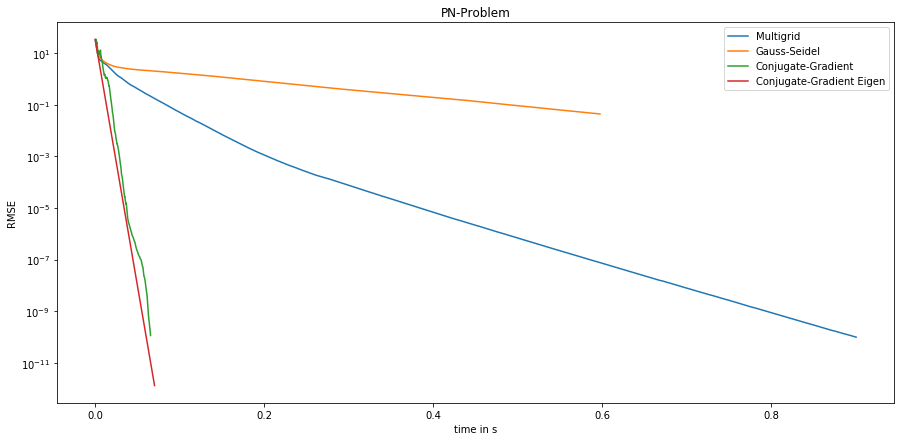

In [78]:
def plot_timings( filename ):
    data = scipy.io.loadmat(filename)
    convergence_mg = data["convergence_mg"][0]
    convergence_time_mg = data["timestamps_mg"][0]
    convergence_gs = data["convergence_gs"][0]
    convergence_time_gs = data["timestamps_gs"][0]
    convergence_cg = data["convergence_cg"][0]
    convergence_time_cg = data["timestamps_cg"][0]
    convergence_cg_eigen = data["convergence_cg_eigen"][0]
    convergence_time_cg_eigen = data["timestamps_cg_eigen"][0]
    plt.semilogy( convergence_time_mg, convergence_mg, label="Multigrid" )
    plt.semilogy( convergence_time_gs, convergence_gs, label="Gauss-Seidel" )
    plt.semilogy( convergence_time_cg, convergence_cg, label="Conjugate-Gradient" )
    plt.semilogy( convergence_time_cg_eigen, convergence_cg_eigen, label="Conjugate-Gradient Eigen" )
    
fig = plt.figure(figsize=(15,7));
ax = fig.add_subplot(111)
plt.title("PN-Problem")
filename = "c:/projects/epfl/temp/multigrid/multigrid-master/checkerboard_test.mat"
plot_timings(filename)
plt.legend(loc='best')
plt.xlabel('time in s')
plt.ylabel('RMSE')

plt.show()

Both problems use the same solver code. The only thing which is changed per probem, are the matrices A and the restriction- and interpolation-matrices on each level.

The timings are different, because the standard problem is solved on a much larger grid, which also explains why Gauss-Seidel is just a straigh line there. However, even for much lower resolution, the multigrid solve will always be faster for the standard problem.

The correctness of the Multigrid solver is validated by showing, that its results matches the result from the Conjugate-gradient solver:

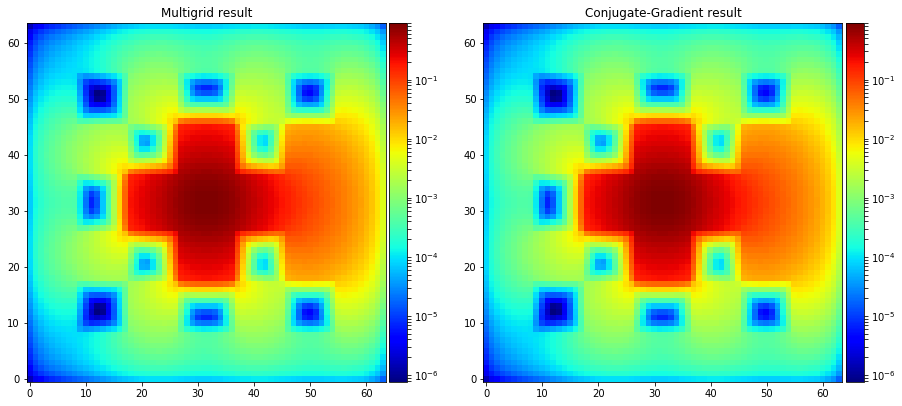

In [70]:
filename = "c:/projects/epfl/temp/multigrid/multigrid-master/checkerboard_test.mat"
data = scipy.io.loadmat(filename)
image_mg = util.extract_coefficient_field( data["x_mg"], data["resolution"][0], data["numCoeffs"][0][0], 0 )
image_mg = np.clip(image_mg, 1.0e-8, np.max(image_mg))
image_cg = util.extract_coefficient_field( data["x_cg"], data["resolution"][0], data["numCoeffs"][0][0], 0 )
image_cg = np.clip(image_cg, 1.0e-8, np.max(image_cg))

fig = plt.figure(figsize=(15,15));
ax = fig.add_subplot(121)
plt.title("Multigrid result")
img_view = ax.imshow(image_mg[:,:,0], cmap='jet', norm=LogNorm(vmin=np.min(image), vmax=np.max(image)), origin='lower')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(img_view, cax=cax)

ax = fig.add_subplot(122)
plt.title("Conjugate-Gradient result")
img_view = ax.imshow(image_cg[:,:,0], cmap='jet', norm=LogNorm(vmin=np.min(image), vmax=np.max(image)), origin='lower')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(img_view, cax=cax)

plt.show()

To make sure, that up- and downsampling works properly, we show the effect of applying up and downsampling matrices to the solution:

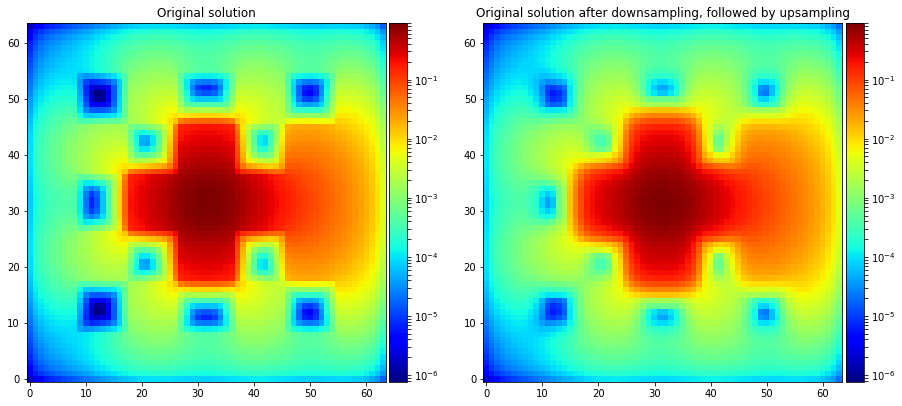

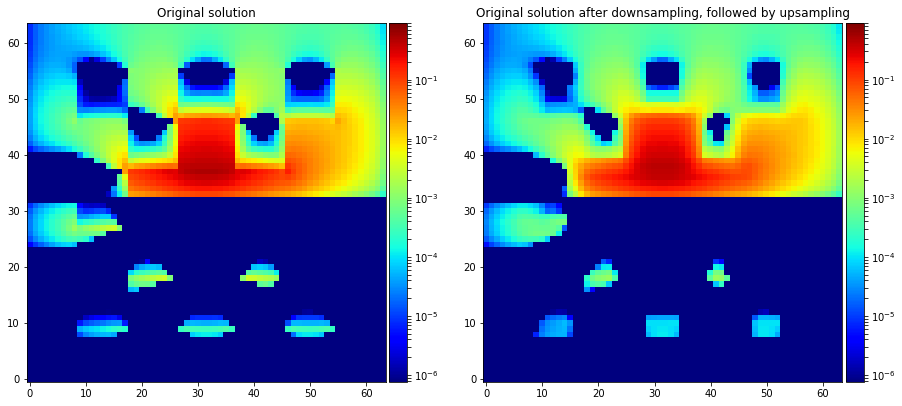

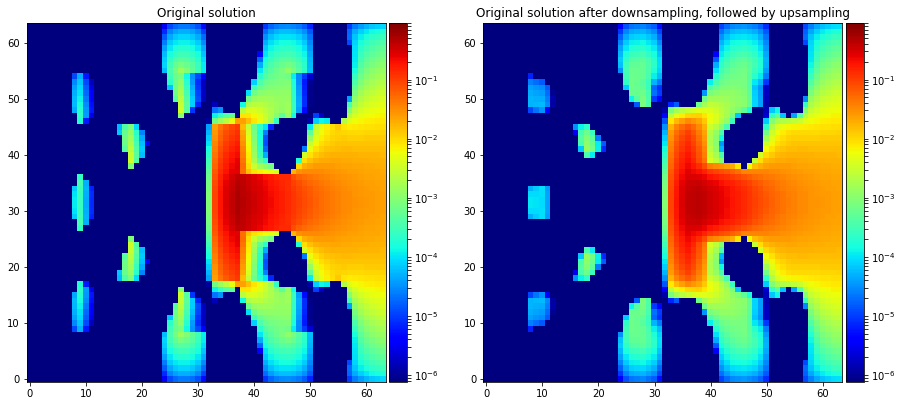

In [76]:
filename = "c:/projects/epfl/temp/multigrid/multigrid-master/checkerboard_test.mat"
numCoeff = data["numCoeffs"][0][0]
for coeff in range(numCoeff):
    data = scipy.io.loadmat(filename)
    image_mg = util.extract_coefficient_field( data["debug_x"], data["resolution"][0], numCoeffs, coeff )
    image_mg = np.clip(image_mg, 1.0e-8, np.max(image_mg))
    image_cg = util.extract_coefficient_field( data["debug_x_upsampled_downsampled"], data["resolution"][0], numCoeffs, coeff )
    image_cg = np.clip(image_cg, 1.0e-8, np.max(image_cg))

    fig = plt.figure(figsize=(15,15));
    ax = fig.add_subplot(121)
    plt.title("Original solution")
    img_view = ax.imshow(image_mg[:,:,0], cmap='jet', norm=LogNorm(vmin=np.min(image), vmax=np.max(image)), origin='lower')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(img_view, cax=cax)

    ax = fig.add_subplot(122)
    plt.title("Original solution after downsampling, followed by upsampling")
    img_view = ax.imshow(image_cg[:,:,0], cmap='jet', norm=LogNorm(vmin=np.min(image), vmax=np.max(image)), origin='lower')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(img_view, cax=cax)

    plt.show()